In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import plotly.express as px

In [2]:
df = pd.read_excel(r"C:\Users\Admin\Desktop\ecommerce retail.xlsx")

In [3]:
df2 = df.dropna(axis = 0)

In [4]:
df2['InvoiceDate'] = pd.to_datetime(df2['InvoiceDate'], format='%Y-%m-%d %H:%M:%S')
df2['CustomerID'] = df2['CustomerID'].astype(np.int64)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  int64         
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 27.9+ MB


C:\Users\Admin\AppData\Local\Temp\ipykernel_16600\2865855300.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['InvoiceDate'] = pd.to_datetime(df2['InvoiceDate'], format='%Y-%m-%d %H:%M:%S')
C:\Users\Admin\AppData\Local\Temp\ipykernel_16600\2865855300.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['CustomerID'] = df2['CustomerID'].astype(np.int64)


In [5]:
data = df2.query('Country=="United Kingdom" and UnitPrice>0 and Quantity>0')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [6]:
df_recency = data.groupby(by='CustomerID', 
                        as_index=False)['InvoiceDate'].max()
df_recency.columns = ['CustomerID', 'MaxPurchaseDate']
recent_date = df_recency['MaxPurchaseDate'].max()
df_recency['Recency'] = df_recency['MaxPurchaseDate'].apply(
    lambda x: (recent_date - x).days)
df_recency.head()

,CustomerID,MaxPurchaseDate,Recency
0,12346,2011-01-18 10:01:00,325
1,12747,2011-12-07 14:34:00,1
2,12748,2011-12-09 12:20:00,0
3,12749,2011-12-06 09:56:00,3
4,12820,2011-12-06 15:12:00,2


In [7]:
frequency_df = data.drop_duplicates().groupby(
    by=['CustomerID'], as_index=False)['InvoiceNo'].count()
frequency_df.columns = ['CustomerID', 'Frequency']
frequency_df.head()

,CustomerID,Frequency
0,12346,1
1,12747,103
2,12748,4412
3,12749,199
4,12820,59


In [8]:
data['Total'] = data['UnitPrice']* data['Quantity']
monetary_df = data.groupby(by='CustomerID', as_index=False)['Total'].sum()
monetary_df.columns = ['CustomerID', 'Monetary']
monetary_df.head()

C:\Users\Admin\AppData\Local\Temp\ipykernel_16600\150361783.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Total'] = data['UnitPrice']* data['Quantity']


,CustomerID,Monetary
0,12346,77183.60
1,12747,4196.01
2,12748,33719.73
3,12749,4090.88
4,12820,942.34


In [9]:
rf_df = df_recency.merge(frequency_df, on='CustomerID')
rfm_df = rf_df.merge(monetary_df, on='CustomerID').drop(columns='MaxPurchaseDate')
rfm_df.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,325,1,77183.60
1,12747,1,103,4196.01
2,12748,0,4412,33719.73
3,12749,3,199,4090.88
4,12820,2,59,942.34


In [10]:
r_labels, f_labels, m_labels = range(5, 0, -1), range(1, 6), range(1, 6)
rfm_df['R_score'] = pd.qcut(rfm_df['Recency'], q=5, labels=r_labels)
rfm_df['F_score'] = pd.qcut(rfm_df['Frequency'].rank(method='first'), q=5, labels=False) + 1
rfm_df['M_score'] = pd.qcut(rfm_df['Monetary'], q=5, labels=m_labels)
rfm_df

,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score
0,12346,325,1,77183.60,1,1,5
1,12747,1,103,4196.01,5,4,5
2,12748,0,4412,33719.73,5,5,5
3,12749,3,199,4090.88,5,5,5
4,12820,2,59,942.34,5,4,4
...,...,...,...,...,...,...,...
3915,18280,277,10,180.60,1,1,1
3916,18281,180,7,80.82,1,1,1
3917,18282,7,12,178.05,5,1,1
3918,18283,3,721,2094.88,5,5,5


In [11]:
rfm_df['RFM_score'] = rfm_df['R_score'].astype(str) + rfm_df['F_score'].astype(str) + rfm_df['M_score'].astype(str)
rfm_df['RFM_score'] = rfm_df['RFM_score'].astype(int)
rfm_df

,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_score
0,12346,325,1,77183.60,1,1,5,115
1,12747,1,103,4196.01,5,4,5,545
2,12748,0,4412,33719.73,5,5,5,555
3,12749,3,199,4090.88,5,5,5,555
4,12820,2,59,942.34,5,4,4,544
...,...,...,...,...,...,...,...,...
3915,18280,277,10,180.60,1,1,1,111
3916,18281,180,7,80.82,1,1,1,111
3917,18282,7,12,178.05,5,1,1,511
3918,18283,3,721,2094.88,5,5,5,555


In [12]:
seg = pd.read_excel(r"C:\Users\Admin\Desktop\segmentation.xlsx")

In [13]:
seg['RFM Score'] = seg['RFM Score'].str.split(',')
seg = seg.explode('RFM Score').reset_index(drop=True)
seg['RFM Score'] = seg['RFM Score'].astype(int)

In [14]:
final_df = rfm_df.merge(seg, left_on='RFM_score', right_on='RFM Score')
final_df

,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_score,Segment,RFM Score
0,12346,325,1,77183.60,1,1,5,115,Cannot Lose Them,115
1,13135,196,1,3096.00,1,1,5,115,Cannot Lose Them,115
2,15098,181,3,39916.50,1,1,5,115,Cannot Lose Them,115
3,15749,234,10,44534.30,1,1,5,115,Cannot Lose Them,115
4,16698,226,5,1998.00,1,1,5,115,Cannot Lose Them,115
...,...,...,...,...,...,...,...,...,...,...
3915,17313,30,24,2328.84,4,2,5,425,Promising,425
3916,17230,263,69,3638.41,1,4,5,145,At Risk,145
3917,17406,332,111,2200.42,1,4,5,145,At Risk,145
3918,17396,38,27,7330.80,3,2,5,325,Need Attention,325


In [15]:
final1_df = final_df.query('Frequency < 300 and Monetary < 4000')
final1_df

,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_score,Segment,RFM Score
1,13135,196,1,3096.00,1,1,5,115,Cannot Lose Them,115
4,16698,226,5,1998.00,1,1,5,115,Cannot Lose Them,115
5,16754,371,2,2002.40,1,1,5,115,Cannot Lose Them,115
8,12906,11,63,2919.81,5,4,5,545,Champions,545
10,13014,10,109,3466.28,5,4,5,545,Champions,545
...,...,...,...,...,...,...,...,...,...,...
3912,16725,301,145,781.02,1,5,3,153,At Risk,153
3913,17472,190,174,710.29,1,5,3,153,At Risk,153
3915,17313,30,24,2328.84,4,2,5,425,Promising,425
3916,17230,263,69,3638.41,1,4,5,145,At Risk,145


In [16]:
final_df['Frequency'].max()

7676

In [17]:
final_df['Monetary'].max()

259657.3

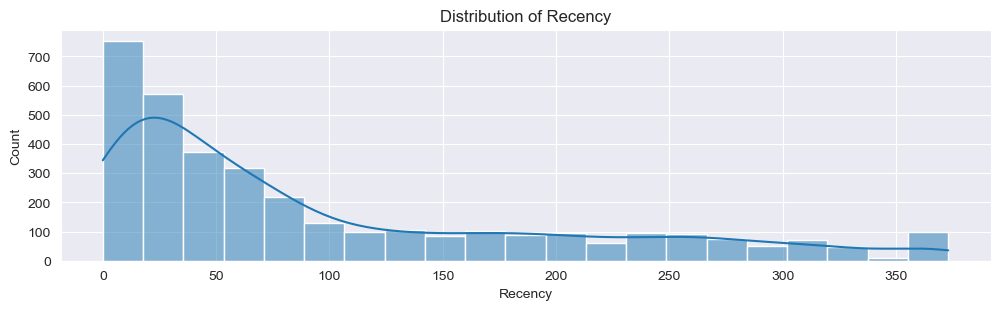

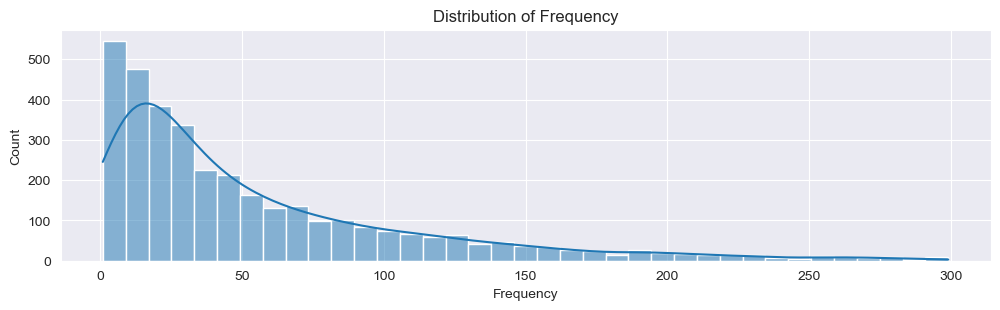

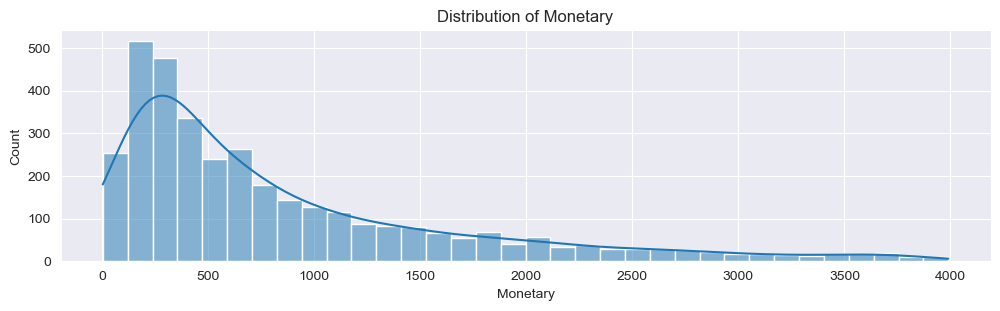

In [59]:
colnames = ['Recency', 'Frequency', 'Monetary']

for col in colnames:
    fig, ax = plt.subplots(figsize=(12, 3))
    sns.histplot(data=final1_df, x=final1_df[col], kde=True)
    ax.set_title('Distribution of %s' %col)
    plt.show()

In [58]:
final2_df = final_df.groupby(['Segment'], as_index=False)['CustomerID'].agg({'Customer_Count':'count'})
fig = px.treemap(data_frame=final2_df, path=['Segment'], values='Customer_Count')
fig.update_layout(title={'text': "Segmentation by Customers",
                         'y':0.9,
                         'x':0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'})
fig.data[0].textinfo = 'label + value + percent root'
fig.show()

In [20]:
fig2 = px.treemap(data_frame=final1_df, path=['Segment'], values='Monetary')
fig2.update_layout(title={'text': "Segmentation by Total Sales",
                         'y':0.9,
                         'x':0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'})
fig2.data[0].textinfo = 'label + value + percent root'
fig2.show()

<Axes: xlabel='Recency', ylabel='Segment'>

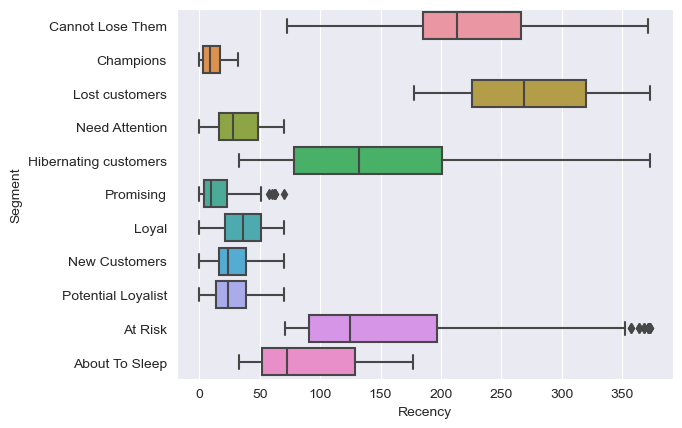

In [62]:
sns.boxplot(x='Recency', y='Segment', data=final1_df)

<Axes: xlabel='Frequency', ylabel='Segment'>

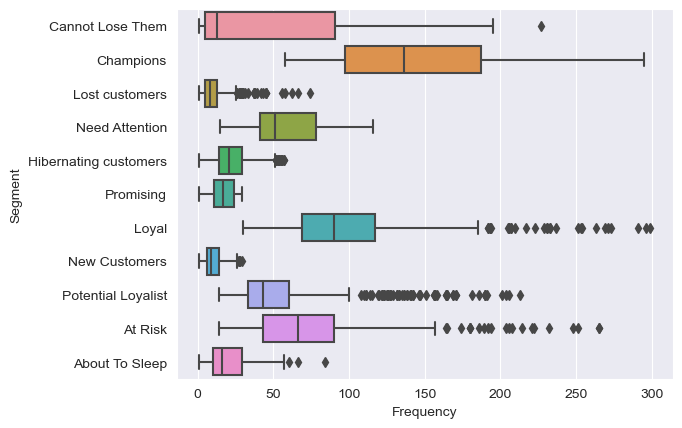

In [57]:
sns.boxplot(x='Frequency', y='Segment', data=final1_df)

<Axes: xlabel='Monetary', ylabel='Segment'>

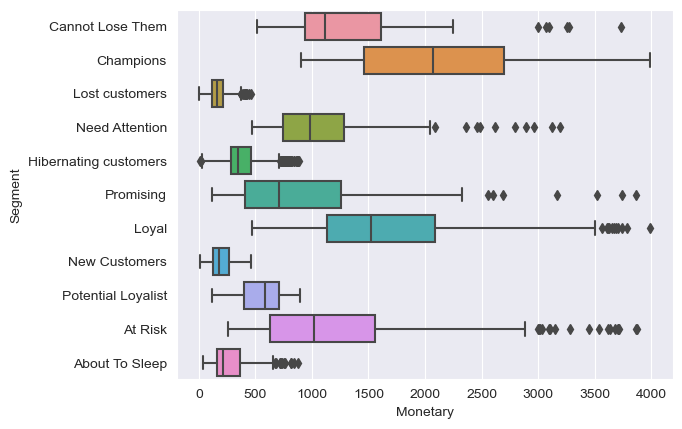

In [61]:
sns.boxplot(x='Monetary', y='Segment', data=final1_df)

In [ ]:
#chúc anh một ngày tốt lành!!!